In [1]:
import os
import sys

ROOT_PATH = os.getcwd()
if "/kaggle" in ROOT_PATH:
    ROOT_PATH = "/kaggle/input"
    sys.path.append(os.path.join(ROOT_PATH, "map-utilities"))

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType

from utils import (
    stringify_input,
    get_model_name,
    get_sequence_classifier,
    get_tokenizer,
    get_training_arguments,
    get_trainer,
)

In [3]:
EPOCHS = 3
MODEL_NAME = get_model_name("/kaggle" in ROOT_PATH, ROOT_PATH)
USE_LORA = False

TRAIN_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "train.csv")
TEST_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "test.csv")

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [5]:
print("Training Shape:", train_df.shape)
print("Testing Shape:", test_df.shape)

Training Shape: (36696, 7)
Testing Shape: (3, 5)


In [6]:
train_df.Misconception = train_df.Misconception.fillna("NA")

In [7]:
train_df["predict"] = train_df.Category + ":" + train_df.Misconception

In [8]:
idx = train_df.Category.str.contains("True", case=False)
tmp = train_df.loc[idx].copy()
tmp["c"] = tmp.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
tmp = tmp.sort_values("c", ascending=False)
tmp = tmp.drop_duplicates(["QuestionId"])
tmp = tmp[["QuestionId", "MC_Answer"]]
tmp["is_mc_answer_correct"] = True

train_df = train_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)

test_df = test_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)

/tmp/ipykernel_43151/1307861462.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)
/tmp/ipykernel_43151/1307861462.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)


In [9]:
train_df["is_student_explanation_correct"] = train_df.Category.apply(
    lambda x: 0 if "Neither" in x else (1 if "Correct" in x else 2)
)

In [10]:
le = LabelEncoder()

train_df["label"] = le.fit_transform(train_df["predict"])
n_classes = len(le.classes_)
print(f"Train shape: {train_df.shape} with {n_classes} predict classes")

Train shape: (36696, 11) with 65 predict classes


In [11]:
joblib.dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [12]:
train_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,predict,is_mc_answer_correct,is_student_explanation_correct,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,True,1,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,True,1,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,True,0,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,True,0,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,True,1,37


In [13]:
model_train_df, model_val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [14]:
model_train_df["stringified_input"] = model_train_df.apply(stringify_input, axis=1)

model_train_df.stringified_input.values[:5]

array(["[CLS] [SEP] Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \\( 6 \\) ? [SEP] Answer: \\( 26 \\) [SEP] The student's answer is correct. [SEP] Student's Explanation: apart from the first it add's 4 every time",
       "[CLS] [SEP] Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.] [SEP] Answer: \\( \\frac{3}{9} \\) [SEP] The student's answer is incorrect. [SEP] Student's Explanation: There are 9 triangles and 3 arent shaded so this means it would be 9/3.",
       "[CLS] [SEP] Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there 

In [15]:
# model_val_df.drop(columns=["is_student_explanation_correct"], inplace=True)
model_val_df["stringified_input"] = model_val_df.apply(stringify_input, axis=1)

model_val_df.stringified_input.values[:5]

array(['[CLS] [SEP] Question: The probability of an event occurring is \\( 0.9 \\).\n\nWhich of the following most accurately describes the likelihood of the event occurring? [SEP] Answer: Likely [SEP] The student\'s answer is correct. [SEP] Student\'s Explanation: i think it\'s b because if it\'s certain, you\'re saying that it will happen 100%;however, the number is 0.9 and it isn\'t "certain" so therefore it would be likely',
       "[CLS] [SEP] Question: Sally has \\( \\frac{2}{3} \\) of a whole cake in the fridge. Robert eats \\( \\frac{1}{3} \\) of this piece. What fraction of the whole cake has Robert eaten?\nChoose the number sentence that would solve the word problem. [SEP] Answer: \\( \\frac{2}{3}-\\frac{1}{3} \\) [SEP] The student's answer is incorrect. [SEP] Student's Explanation: roberts takes half of the 2/3 so it is -",
       "[CLS] [SEP] Question: Calculate \\( \\frac{2}{3} \\times 5 \\) [SEP] Answer: \\( 3 \\frac{1}{3} \\) [SEP] The student's answer is correct. [SEP] 

In [16]:
COLUMNS = ["stringified_input", "label"]

train_ds = Dataset.from_pandas(model_train_df[COLUMNS])
val_ds = Dataset.from_pandas(model_val_df[COLUMNS])

In [17]:
seq_model = get_sequence_classifier(MODEL_NAME, n_classes)
tokenizer = get_tokenizer(MODEL_NAME)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
if USE_LORA:
    peft_config = LoraConfig(
        r=4,
        lora_alpha=16,
        target_modules=["query_proj", "key_proj", "value_proj", "dense"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    seq_model = get_peft_model(seq_model, peft_config)

    for name, p in seq_model.named_parameters():
        if "lora" not in name:
            p.requires_grad = False

In [19]:
def tokenize_function(examples):
    return tokenizer(examples["stringified_input"], truncation=True, padding="max_length", max_length=512)

In [20]:
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [21]:
training_args = get_training_arguments(
    epochs=EPOCHS,
    train_batch_size=16,
    eval_batch_size=32,
    bf16_support="/kaggle" in ROOT_PATH,
)
trainer = get_trainer(
    seq_model,
    tokenizer,
    training_args,
    train_ds,
    val_ds,
)

/home/maitri/Downloads/dev/map-kaggle-competition/src/utils.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [22]:
trainer.train()

Step,Training Loss,Validation Loss,Map@3
200,1.131900,1.043167,0.800000
400,0.912000,0.683343,0.865781
600,0.713900,0.721872,0.869800
800,0.583900,0.602123,0.880836
1000,0.481000,0.554184,0.899205
1200,0.473000,0.489123,0.911172
1400,0.456800,0.472080,0.915917
1600,0.438400,0.401861,0.927384
1800,0.424400,0.468098,0.913420
2000,0.342500,0.429385,0.924319


TrainOutput(global_step=5505, training_loss=0.4182409933542361, metrics={'train_runtime': 13320.1594, 'train_samples_per_second': 6.612, 'train_steps_per_second': 0.413, 'total_flos': 9.315431321411174e+16, 'train_loss': 0.4182409933542361, 'epoch': 3.0})

In [23]:
logs = pd.DataFrame(trainer.state.log_history)
train_loss = logs[logs["loss"].notna()][["step", "loss"]]
eval_loss = logs[logs["eval_loss"].notna()][["step", "eval_loss"]]

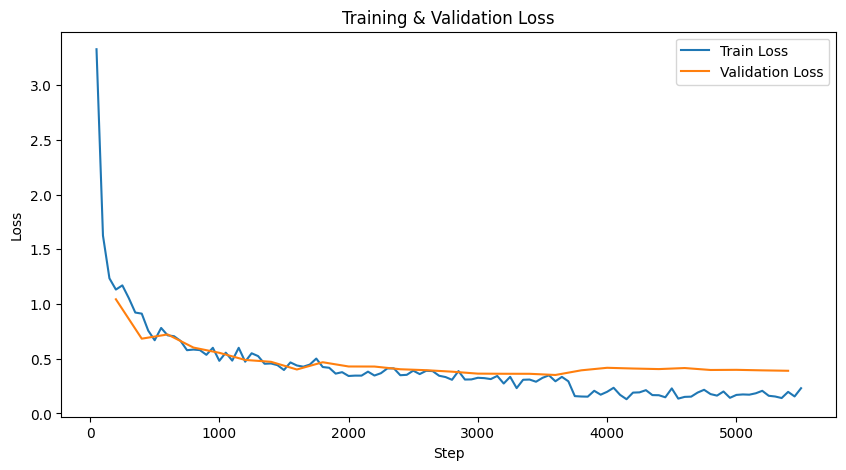

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [25]:
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True


In [26]:
test_df["stringified_input"] = test_df.apply(stringify_input, axis=1)
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct,stringified_input
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True,[CLS] [SEP] Question: What fraction of the sha...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False,[CLS] [SEP] Question: What fraction of the sha...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True,[CLS] [SEP] Question: Which number is the grea...


In [27]:
test_ds = Dataset.from_pandas(test_df[["stringified_input"]])
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [28]:
predictions = trainer.predict(test_ds)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

In [29]:
top3 = np.argsort(-probs, axis=1)[:, :3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test_df.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
